# Implementation of Vanilla GANs model with Gaussian dataset
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [0]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

import numpy as np
import datetime
import os, sys
import random

import sklearn.datasets

random.seed(42)
np.random.seed(42)

from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn

%matplotlib inline

In [0]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")
DATASET = '25gaussians'
NO_OF_BATCHES = 100
BATCH_SIZE = 64
max_epoch = 100 # need more than 10 epochs for training generator
st = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 2
population  = 10
verbose  = 1
plot = 1

best_per_gen = 5


In [0]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
#             nn.ReLU(True),
#             nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [0]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
#             nn.ReLU(True),
#             nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [0]:
def generate_image(dist, G):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    
#     plt.subplot(1,2,1)
    
#     for idx in range(NO_OF_BATCHES):
#         plt.scatter(dist[idx][:,0], dist[idx][:,1], c='green', edgecolor='none',alpha=0.6)

    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    z_outputs = G(z)
    
    z_outputs = z_outputs.cpu().detach().numpy()
    
#     plt.scatter(z_outputs[:,0], z_outputs[:,1], edgecolor='none',alpha=0.6)
    
#     #source https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/gradient_regularized_gan_gaussian_toy_problem.ipynb
#     plt.subplot(1,2,2)
    seaborn.kdeplot(z_outputs[:, 0], z_outputs[:, 1], shade=True, cmap='Greens', n_levels=10)  #, clip=[[-2.5,2.5]]*2)
    plt.gca().set_facecolor(seaborn.color_palette('Greens', n_colors=256)[0])
     
    plt.show()
    
#     clear_output(wait=True)

In [0]:
def inf_train_gen():
    if DATASET == '25gaussians':

        dataset = []
        for i in range(int(100000 / 25)):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        np.random.shuffle(dataset)
        dataset /= 2.828  # stdev
        while True:
            for i in range(int(len(dataset) / BATCH_SIZE)):
                yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE,
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data

    elif DATASET == '8gaussians':

        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2) * .02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype='float32')
            dataset /= 1.414  # stdev
            yield dataset


In [0]:


# D = Discriminator().to(DEVICE)
# G = Generator(n_noise).to(DEVICE)

criterion = nn.BCELoss()
# D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) #lr = 0.0002 
# G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

data = inf_train_gen()

train = []

for _ in range(NO_OF_BATCHES):
    data_ = next(data)
    train.append(data_)

train = np.array(train)

In [0]:
# generate_image(train)

## Training time: ~420-430s

In [0]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('runs')

In [0]:
def train_GAN(Gen, Disc, G_optim, D_optim, verbose, plot, indiv):
    st = 0
    for epoch in range(1, max_epoch+1):
        for idx, x in enumerate(train):
            # Training Discriminator

            x = torch.Tensor(x)

            if DEVICE == torch.device("cuda"):
                x = x.cuda()

            x = torch.autograd.Variable(x)  
            x_outputs = Disc(x)      

            D_x_loss = criterion(x_outputs, D_labels)
            
#             mean_disc = torch.mean(x_outputs)

            z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
            z_outputs = Disc(Gen(z))
            D_z_loss = criterion(z_outputs, D_fakes)
            D_loss = D_x_loss + D_z_loss
            
#             D_loss.register_hook(lambda grad: print(grad))
            
            Disc.zero_grad()
            D_loss.backward(retain_graph=True)
            D_optim.step()
            
            #Compute gradient at the discriminator 
            grads = torch.autograd.grad(D_loss, Disc.parameters(), create_graph=True)
            gr_norm_sq = 0.0
            for gr in grads:
                gr_norm_sq += (gr**2).sum()

            if st % n_critic == 0:
                # Training Generator
                z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
                z_outputs = Disc(Gen(z))
                G_loss = criterion(z_outputs, D_labels)    #Loss function modified to log(D(G(z))) instead of 1 - log(D(G(z))) as given in the paper. (Find suitable reference)
                
                Gen.zero_grad()
                G_loss.backward()
                G_optim.step()

    #         writer.add_scalar('Discriminator loss',D_loss.item(),idx)
    #         writer.add_scalar('Generator loss',G_loss.item(),idx)
            
            if st % 500 == 0 and verbose:
                print('Individual: {}, Epoch: {}/{}, Step: {}, D_Loss: {}, G Loss: {}'.format(indiv+1, epoch, max_epoch, st, D_loss, G_loss))
                #if st % 5000 == 0 and plot:
                    #generate_image(train)
            st += 1

    print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}, Discriminator Gradient: {}'.format(epoch, max_epoch, st, D_loss.item(), G_loss.item(), gr_norm_sq ))
    if plot:
        generate_image(train, Gen)
    
    return Gen, Disc
    

#     writer.export_scalars_to_json('./all_Scalars.json')
#     writer.close()

In [0]:
# verbose  = 1
# plot = 0


# train_GAN(G, D, verbose, plot)

In [0]:
def fitness_func (list_Gen, list_Disc, train, population):
    
    real_samples = train.reshape(-1,2)
    
    real_samples = torch.Tensor(real_samples)

    if DEVICE == torch.device("cuda"):
        real_samples = real_samples.cuda()
    
    true_labs = torch.ones(BATCH_SIZE*NO_OF_BATCHES, 1).to(DEVICE)
    fake_labs = torch.zeros(BATCH_SIZE*NO_OF_BATCHES, 1).to(DEVICE)
    
    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    
    Gen_losses  = []
    Disc_losses = []
    
    for o_idx in range(population):
        G_loss_temp = 0
        D_loss_temp = 0
        
        Gen_o  = list_Gen[o_idx]
        Disc_o = list_Disc[o_idx]
        
#         print(type(real_samples))
#         real_samples = torch.from_numpy(real_samples)
        x_outputs = Disc_o(real_samples)      

        D_loss_temp = criterion(x_outputs, true_labs)
            
        for i_idx in range(population):

            Disc_i = list_Disc[i_idx]
                
            z_outputs = Disc_i(Gen_o(z))
            G_loss_temp += criterion(z_outputs, true_labs)    

            Gen_i  = list_Gen[i_idx]
            
            z_outputs = Disc_o(Gen_i(z))
            D_loss_temp += criterion(z_outputs, fake_labs)
            
        Gen_losses.append(G_loss_temp.item())
        Disc_losses.append(D_loss_temp.item())
    
    Gen_losses = np.array(Gen_losses)
    Disc_losses = np.array(Disc_losses)
    
    return Gen_losses, Disc_losses
            
        
            
    
    

In [0]:
def initialize_pop(population):

    Discs_GA = []
    Gens_GA  = []

    for _ in range(population):
        D_temp = Discriminator().to(DEVICE)
        G_temp = Generator(n_noise).to(DEVICE)

        Discs_GA.append(D_temp)
        Gens_GA.append(G_temp)
    
    return Gens_GA, Discs_GA

In [0]:
#     Discs_GA = []
#     Gens_GA  = []

#     for _ in range(population):
#         D_temp = Discriminator().to(DEVICE)
#         G_temp = Generator(n_noise).to(DEVICE)

#         Discs_GA.append(D_temp)
#         Gens_GA.append(G_temp)

In [0]:
# trained_Gen  = []
# trained_Disc = []

# for p in range(population):
#     print('Individual: {}'.format(p+1))
    
#     D_opt_temp = torch.optim.Adam(Discs_GA[p].parameters(), lr=0.0002, betas=(0.5, 0.999)) #lr = 0.0002 
#     G_opt_temp = torch.optim.Adam(Gens_GA[p].parameters(), lr=0.0002, betas=(0.5, 0.999))
    
#     Gen, Disc = train_GAN(Gens_GA[p], Discs_GA[p], G_opt_temp, D_opt_temp, verbose, 1, p)
#     trained_Gen.append(Gen)
#     trained_Disc.append(Disc)

In [18]:
# Gens_loss, Discs_loss = fitness_func(trained_Gen, trained_Disc, train, population)
# print(Gens_loss)
# print(Discs_loss)

NameError: ignored

In [0]:
def visualize_gens(G):

    for p in range(population):
        print('Generator: {}'.format(p+1))
        generate_image(train, G[p])



In [0]:
def crossover(list_Gs, list_Ds, population):
    
    num_copies = int(population/best_per_gen)
    
    list_Gs = list_Gs * num_copies
    list_Ds = list_Ds * num_copies
    
    random.shuffle(list_Gs)
    random.shuffle(list_Ds)
    
    return list_Gs, list_Ds

In [0]:
def train_pop(list_Gs, list_Ds, population):
    
    trained_Gen  = []
    trained_Disc = []

    for p in range(population):

        print('Individual: {}'.format(p+1))

        D_opt_temp = torch.optim.Adam(list_Ds[p].parameters(), lr=0.0002, betas=(0.5, 0.999)) #lr = 0.0002 
        G_opt_temp = torch.optim.Adam(list_Gs[p].parameters(), lr=0.0002, betas=(0.5, 0.999))

        Gen, Disc = train_GAN(list_Gs[p], list_Ds[p], G_opt_temp, D_opt_temp, verbose, plot, p)
        trained_Gen.append(Gen)
        trained_Disc.append(Disc)
        
    return trained_Gen, trained_Disc
    
    

In [0]:
def GA(Generations, population):
    
    #Initialize population
    G, D = initialize_pop(population)
    
    trained_GA_G = []
    trained_GA_D = []
    
    fit_GA_G = []
    fit_GA_D = []
        
    for gen in range(Generations):
        
        print('Generation: {}'.format(gen+1))
        
        #Training for Evaluation
        
        print('Training for Evaluation....Generation: {}'.format(gen+1))
        
        trained_Gen, trained_Disc = train_pop(G, D, population)
                   
        trained_GA_G.append(trained_Gen)
        trained_GA_D.append(trained_Disc)
        
        G_fit, D_fit = fitness_func(trained_Gen, trained_Disc, train, population)
        
        fit_GA_G.append(G_fit)
        fit_GA_D.append(D_fit)
               
        best_Gs = sorted(range(len(G_fit)), key=lambda i: G_fit[i], reverse=False)[:best_per_gen]
        best_Ds = sorted(range(len(D_fit)), key=lambda i: D_fit[i], reverse=False)[:best_per_gen]
        
        #Training for Mutuation
        
        print('Mutating....Generation: {}'.format(gen+1))
        
        mut_G = [G[G_idx] for G_idx in best_Gs]
        mut_D = [D[D_idx] for D_idx in best_Ds]
        
        mutated_Gs, mutated_Ds = train_pop(mut_G, mut_D, best_per_gen)
               
        print('Crossover....Generation: {}'.format(gen+1))
        
        G, D = crossover(mutated_Gs, mutated_Ds, population)
        
        
    return G,D
        
        
        
        
        
    
    

Generation: 1
Training for Evaluation....Generation: 1
Individual: 1
Individual: 1, Epoch: 1/100, Step: 0, D_Loss: 1.3722712993621826, G Loss: 0.6452305316925049
Individual: 1, Epoch: 6/100, Step: 500, D_Loss: 1.0911730527877808, G Loss: 0.9038008451461792
Individual: 1, Epoch: 11/100, Step: 1000, D_Loss: 1.3767917156219482, G Loss: 0.6925871968269348
Individual: 1, Epoch: 16/100, Step: 1500, D_Loss: 1.37959885597229, G Loss: 0.696782112121582
Individual: 1, Epoch: 21/100, Step: 2000, D_Loss: 1.3677432537078857, G Loss: 0.692142903804779
Individual: 1, Epoch: 26/100, Step: 2500, D_Loss: 1.3566837310791016, G Loss: 0.6841650009155273
Individual: 1, Epoch: 31/100, Step: 3000, D_Loss: 1.3617278337478638, G Loss: 0.7475773096084595
Individual: 1, Epoch: 36/100, Step: 3500, D_Loss: 1.3244291543960571, G Loss: 0.7754004001617432
Individual: 1, Epoch: 41/100, Step: 4000, D_Loss: 1.2823563814163208, G Loss: 0.7742880582809448
Individual: 1, Epoch: 46/100, Step: 4500, D_Loss: 1.233818531036377,

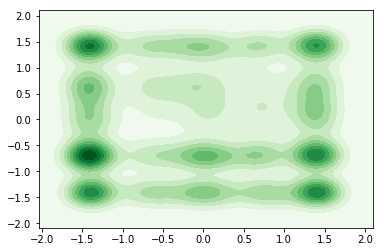

Individual: 2
Individual: 2, Epoch: 1/100, Step: 0, D_Loss: 1.3541234731674194, G Loss: 0.5869990587234497
Individual: 2, Epoch: 6/100, Step: 500, D_Loss: 1.3748893737792969, G Loss: 0.6980528235435486
Individual: 2, Epoch: 11/100, Step: 1000, D_Loss: 1.3707724809646606, G Loss: 0.6784236431121826
Individual: 2, Epoch: 16/100, Step: 1500, D_Loss: 1.3745863437652588, G Loss: 0.6995413303375244
Individual: 2, Epoch: 21/100, Step: 2000, D_Loss: 1.376389980316162, G Loss: 0.7008906602859497
Individual: 2, Epoch: 26/100, Step: 2500, D_Loss: 1.3960089683532715, G Loss: 0.7220982313156128
Individual: 2, Epoch: 31/100, Step: 3000, D_Loss: 1.3475193977355957, G Loss: 0.7386575937271118
Individual: 2, Epoch: 36/100, Step: 3500, D_Loss: 1.308365821838379, G Loss: 0.7839138507843018
Individual: 2, Epoch: 41/100, Step: 4000, D_Loss: 1.2920292615890503, G Loss: 0.8036348819732666
Individual: 2, Epoch: 46/100, Step: 4500, D_Loss: 1.2232872247695923, G Loss: 0.8426427245140076
Individual: 2, Epoch: 51

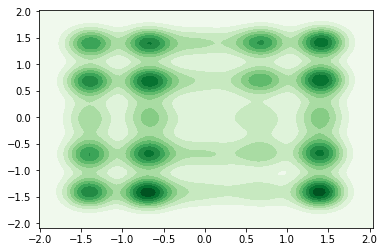

Individual: 3
Individual: 3, Epoch: 1/100, Step: 0, D_Loss: 1.4245185852050781, G Loss: 0.6869917511940002
Individual: 3, Epoch: 6/100, Step: 500, D_Loss: 1.3749334812164307, G Loss: 0.6943049430847168
Individual: 3, Epoch: 11/100, Step: 1000, D_Loss: 1.3765791654586792, G Loss: 0.7076058983802795
Individual: 3, Epoch: 16/100, Step: 1500, D_Loss: 1.3885672092437744, G Loss: 0.7095329165458679
Individual: 3, Epoch: 21/100, Step: 2000, D_Loss: 1.3545801639556885, G Loss: 0.7104058265686035
Individual: 3, Epoch: 26/100, Step: 2500, D_Loss: 1.3383617401123047, G Loss: 0.73191899061203
Individual: 3, Epoch: 31/100, Step: 3000, D_Loss: 1.2971588373184204, G Loss: 0.7602028846740723
Individual: 3, Epoch: 36/100, Step: 3500, D_Loss: 1.2950725555419922, G Loss: 0.7428574562072754
Individual: 3, Epoch: 41/100, Step: 4000, D_Loss: 1.260546088218689, G Loss: 0.8282251358032227
Individual: 3, Epoch: 46/100, Step: 4500, D_Loss: 1.1865357160568237, G Loss: 0.7927352786064148
Individual: 3, Epoch: 51/

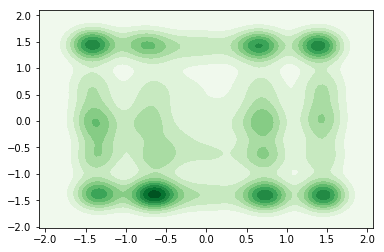

Individual: 4
Individual: 4, Epoch: 1/100, Step: 0, D_Loss: 1.3627278804779053, G Loss: 0.6527681946754456
Individual: 4, Epoch: 6/100, Step: 500, D_Loss: 1.3621275424957275, G Loss: 0.6243284940719604
Individual: 4, Epoch: 11/100, Step: 1000, D_Loss: 1.3863139152526855, G Loss: 0.6882514357566833
Individual: 4, Epoch: 16/100, Step: 1500, D_Loss: 1.3804187774658203, G Loss: 0.6835902333259583
Individual: 4, Epoch: 21/100, Step: 2000, D_Loss: 1.3667258024215698, G Loss: 0.7185481786727905
Individual: 4, Epoch: 26/100, Step: 2500, D_Loss: 1.3592168092727661, G Loss: 0.7131072282791138
Individual: 4, Epoch: 31/100, Step: 3000, D_Loss: 1.3596463203430176, G Loss: 0.7477827072143555
Individual: 4, Epoch: 36/100, Step: 3500, D_Loss: 1.3262879848480225, G Loss: 0.7491838932037354
Individual: 4, Epoch: 41/100, Step: 4000, D_Loss: 1.3318767547607422, G Loss: 0.8112128973007202
Individual: 4, Epoch: 46/100, Step: 4500, D_Loss: 1.2697603702545166, G Loss: 0.7662323713302612
Individual: 4, Epoch: 

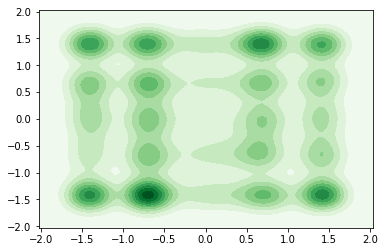

Individual: 5
Individual: 5, Epoch: 1/100, Step: 0, D_Loss: 1.3766331672668457, G Loss: 0.7182177305221558
Individual: 5, Epoch: 6/100, Step: 500, D_Loss: 1.3928635120391846, G Loss: 0.7489289045333862
Individual: 5, Epoch: 11/100, Step: 1000, D_Loss: 1.3811471462249756, G Loss: 0.6879953145980835
Individual: 5, Epoch: 16/100, Step: 1500, D_Loss: 1.3651652336120605, G Loss: 0.695417582988739
Individual: 5, Epoch: 21/100, Step: 2000, D_Loss: 1.3721506595611572, G Loss: 0.7056483030319214
Individual: 5, Epoch: 26/100, Step: 2500, D_Loss: 1.35917067527771, G Loss: 0.7087452411651611
Individual: 5, Epoch: 31/100, Step: 3000, D_Loss: 1.333409070968628, G Loss: 0.7612656950950623
Individual: 5, Epoch: 36/100, Step: 3500, D_Loss: 1.298143744468689, G Loss: 0.7711295485496521
Individual: 5, Epoch: 41/100, Step: 4000, D_Loss: 1.3104801177978516, G Loss: 0.7629310488700867
Individual: 5, Epoch: 46/100, Step: 4500, D_Loss: 1.2483086585998535, G Loss: 0.7802102565765381
Individual: 5, Epoch: 51/10

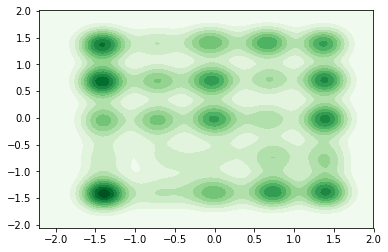

Individual: 6
Individual: 6, Epoch: 1/100, Step: 0, D_Loss: 1.3756697177886963, G Loss: 0.7229158878326416
Individual: 6, Epoch: 6/100, Step: 500, D_Loss: 1.376384973526001, G Loss: 0.7045924067497253
Individual: 6, Epoch: 11/100, Step: 1000, D_Loss: 1.3772156238555908, G Loss: 0.6839115619659424
Individual: 6, Epoch: 16/100, Step: 1500, D_Loss: 1.3798460960388184, G Loss: 0.6999784111976624
Individual: 6, Epoch: 21/100, Step: 2000, D_Loss: 1.3601787090301514, G Loss: 0.7148852348327637
Individual: 6, Epoch: 26/100, Step: 2500, D_Loss: 1.3642507791519165, G Loss: 0.739071249961853
Individual: 6, Epoch: 31/100, Step: 3000, D_Loss: 1.3716285228729248, G Loss: 0.7486996650695801
Individual: 6, Epoch: 36/100, Step: 3500, D_Loss: 1.3100842237472534, G Loss: 0.7343369722366333
Individual: 6, Epoch: 41/100, Step: 4000, D_Loss: 1.2765464782714844, G Loss: 0.7865796685218811
Individual: 6, Epoch: 46/100, Step: 4500, D_Loss: 1.208045244216919, G Loss: 0.8359377384185791
Individual: 6, Epoch: 51/

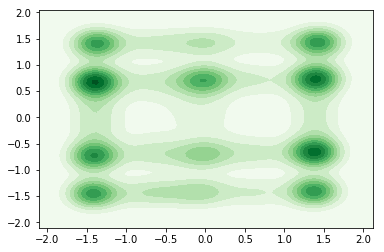

Individual: 7
Individual: 7, Epoch: 1/100, Step: 0, D_Loss: 1.3728022575378418, G Loss: 0.7079167366027832
Individual: 7, Epoch: 6/100, Step: 500, D_Loss: 1.0891615152359009, G Loss: 0.9209467768669128
Individual: 7, Epoch: 11/100, Step: 1000, D_Loss: 1.5655028820037842, G Loss: 0.6017329692840576
Individual: 7, Epoch: 16/100, Step: 1500, D_Loss: 1.0695679187774658, G Loss: 0.9137939214706421
Individual: 7, Epoch: 21/100, Step: 2000, D_Loss: 1.4115257263183594, G Loss: 0.609047532081604
Individual: 7, Epoch: 26/100, Step: 2500, D_Loss: 1.4181571006774902, G Loss: 0.7331289052963257
Individual: 7, Epoch: 31/100, Step: 3000, D_Loss: 1.3519681692123413, G Loss: 0.7158985137939453
Individual: 7, Epoch: 36/100, Step: 3500, D_Loss: 1.3765393495559692, G Loss: 0.6807498931884766
Individual: 7, Epoch: 41/100, Step: 4000, D_Loss: 1.356473445892334, G Loss: 0.7080354690551758
Individual: 7, Epoch: 46/100, Step: 4500, D_Loss: 1.344673752784729, G Loss: 0.7336097955703735
Individual: 7, Epoch: 51/

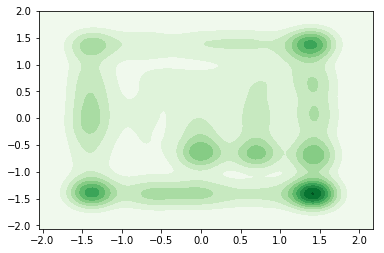

Individual: 8
Individual: 8, Epoch: 1/100, Step: 0, D_Loss: 1.4070473909378052, G Loss: 0.7744589447975159
Individual: 8, Epoch: 6/100, Step: 500, D_Loss: 1.5835758447647095, G Loss: 0.6339360475540161
Individual: 8, Epoch: 11/100, Step: 1000, D_Loss: 1.2972331047058105, G Loss: 0.8742620944976807
Individual: 8, Epoch: 16/100, Step: 1500, D_Loss: 1.5392175912857056, G Loss: 0.5824472308158875
Individual: 8, Epoch: 21/100, Step: 2000, D_Loss: 1.282509207725525, G Loss: 0.7737953662872314
Individual: 8, Epoch: 26/100, Step: 2500, D_Loss: 1.1586490869522095, G Loss: 0.9572509527206421
Individual: 8, Epoch: 31/100, Step: 3000, D_Loss: 1.344941258430481, G Loss: 0.7042626142501831
Individual: 8, Epoch: 36/100, Step: 3500, D_Loss: 1.3523526191711426, G Loss: 0.6929071545600891
Individual: 8, Epoch: 41/100, Step: 4000, D_Loss: 1.3302662372589111, G Loss: 0.7422729730606079
Individual: 8, Epoch: 46/100, Step: 4500, D_Loss: 1.3250970840454102, G Loss: 0.7481464147567749
Individual: 8, Epoch: 51

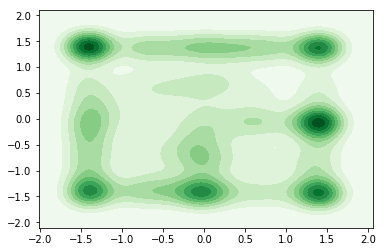

Individual: 9
Individual: 9, Epoch: 1/100, Step: 0, D_Loss: 1.3620630502700806, G Loss: 0.6607612371444702
Individual: 9, Epoch: 6/100, Step: 500, D_Loss: 1.0642333030700684, G Loss: 0.9318243265151978
Individual: 9, Epoch: 11/100, Step: 1000, D_Loss: 1.3860185146331787, G Loss: 0.6922568082809448
Individual: 9, Epoch: 16/100, Step: 1500, D_Loss: 1.3763432502746582, G Loss: 0.7037370204925537
Individual: 9, Epoch: 21/100, Step: 2000, D_Loss: 1.3696722984313965, G Loss: 0.6968132257461548
Individual: 9, Epoch: 26/100, Step: 2500, D_Loss: 1.358902931213379, G Loss: 0.7106685638427734
Individual: 9, Epoch: 31/100, Step: 3000, D_Loss: 1.3601785898208618, G Loss: 0.7132170796394348
Individual: 9, Epoch: 36/100, Step: 3500, D_Loss: 1.314701795578003, G Loss: 0.753879964351654
Individual: 9, Epoch: 41/100, Step: 4000, D_Loss: 1.2571418285369873, G Loss: 0.7738358378410339
Individual: 9, Epoch: 46/100, Step: 4500, D_Loss: 1.2184231281280518, G Loss: 0.8171650767326355
Individual: 9, Epoch: 51/

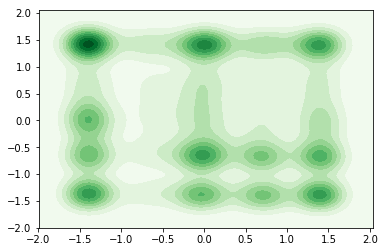

Individual: 10
Individual: 10, Epoch: 1/100, Step: 0, D_Loss: 1.4074070453643799, G Loss: 0.7062505483627319
Individual: 10, Epoch: 6/100, Step: 500, D_Loss: 1.3799448013305664, G Loss: 0.6952161192893982
Individual: 10, Epoch: 11/100, Step: 1000, D_Loss: 1.3933179378509521, G Loss: 0.7084131836891174
Individual: 10, Epoch: 16/100, Step: 1500, D_Loss: 1.374563455581665, G Loss: 0.6927066445350647
Individual: 10, Epoch: 21/100, Step: 2000, D_Loss: 1.3827838897705078, G Loss: 0.6930397748947144
Individual: 10, Epoch: 26/100, Step: 2500, D_Loss: 1.351705551147461, G Loss: 0.7324032783508301
Individual: 10, Epoch: 31/100, Step: 3000, D_Loss: 1.3300871849060059, G Loss: 0.7682797312736511
Individual: 10, Epoch: 36/100, Step: 3500, D_Loss: 1.2983458042144775, G Loss: 0.7695002555847168
Individual: 10, Epoch: 41/100, Step: 4000, D_Loss: 1.2590773105621338, G Loss: 0.8389009833335876
Individual: 10, Epoch: 46/100, Step: 4500, D_Loss: 1.2583508491516113, G Loss: 0.836158037185669
Individual: 10

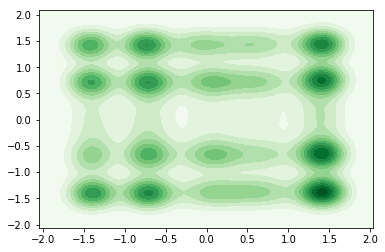

Mutating....Generation: 1
Individual: 1
Individual: 1, Epoch: 1/100, Step: 0, D_Loss: 1.2375763654708862, G Loss: 0.9779101610183716
Individual: 1, Epoch: 6/100, Step: 500, D_Loss: 1.1260302066802979, G Loss: 1.2280502319335938
Individual: 1, Epoch: 11/100, Step: 1000, D_Loss: 1.1063828468322754, G Loss: 0.9556604027748108
Individual: 1, Epoch: 16/100, Step: 1500, D_Loss: 1.191084861755371, G Loss: 1.0281753540039062
Individual: 1, Epoch: 21/100, Step: 2000, D_Loss: 1.0535755157470703, G Loss: 0.886317789554596
Individual: 1, Epoch: 26/100, Step: 2500, D_Loss: 1.1898678541183472, G Loss: 1.1019353866577148
Individual: 1, Epoch: 31/100, Step: 3000, D_Loss: 1.1711844205856323, G Loss: 1.0212256908416748
Individual: 1, Epoch: 36/100, Step: 3500, D_Loss: 1.1980639696121216, G Loss: 1.0904080867767334
Individual: 1, Epoch: 41/100, Step: 4000, D_Loss: 1.2290289402008057, G Loss: 0.9753317832946777
Individual: 1, Epoch: 46/100, Step: 4500, D_Loss: 1.1683235168457031, G Loss: 0.88706374168396


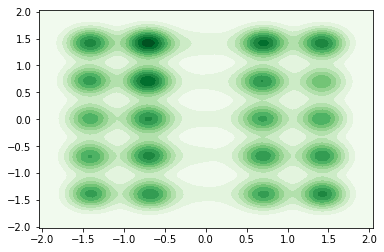

Individual: 2
Individual: 2, Epoch: 1/100, Step: 0, D_Loss: 1.1605368852615356, G Loss: 1.0092604160308838
Individual: 2, Epoch: 6/100, Step: 500, D_Loss: 1.1877284049987793, G Loss: 0.9829290509223938
Individual: 2, Epoch: 11/100, Step: 1000, D_Loss: 1.1391911506652832, G Loss: 0.9194585084915161
Individual: 2, Epoch: 16/100, Step: 1500, D_Loss: 1.1844093799591064, G Loss: 0.9054001569747925
Individual: 2, Epoch: 21/100, Step: 2000, D_Loss: 1.322045087814331, G Loss: 0.9651538133621216
Individual: 2, Epoch: 26/100, Step: 2500, D_Loss: 1.2299211025238037, G Loss: 0.957848846912384
Individual: 2, Epoch: 31/100, Step: 3000, D_Loss: 1.1616261005401611, G Loss: 1.0408599376678467
Individual: 2, Epoch: 36/100, Step: 3500, D_Loss: 1.2198190689086914, G Loss: 0.9701884388923645
Individual: 2, Epoch: 41/100, Step: 4000, D_Loss: 1.2400091886520386, G Loss: 0.997141420841217
Individual: 2, Epoch: 46/100, Step: 4500, D_Loss: 1.2566776275634766, G Loss: 0.9984593391418457
Individual: 2, Epoch: 51/

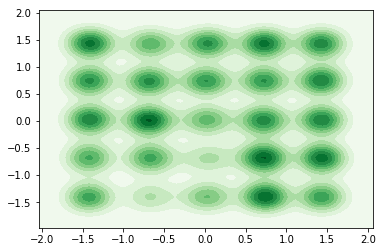

Individual: 3
Individual: 3, Epoch: 1/100, Step: 0, D_Loss: 1.1555931568145752, G Loss: 1.1033294200897217
Individual: 3, Epoch: 6/100, Step: 500, D_Loss: 1.0958449840545654, G Loss: 1.3003404140472412
Individual: 3, Epoch: 11/100, Step: 1000, D_Loss: 1.1163045167922974, G Loss: 1.0083653926849365
Individual: 3, Epoch: 16/100, Step: 1500, D_Loss: 1.1895813941955566, G Loss: 1.1010899543762207
Individual: 3, Epoch: 21/100, Step: 2000, D_Loss: 1.244921088218689, G Loss: 1.3063310384750366
Individual: 3, Epoch: 26/100, Step: 2500, D_Loss: 1.0981251001358032, G Loss: 1.0137869119644165
Individual: 3, Epoch: 31/100, Step: 3000, D_Loss: 1.0981724262237549, G Loss: 0.9528111219406128
Individual: 3, Epoch: 36/100, Step: 3500, D_Loss: 1.0902221202850342, G Loss: 0.8665049076080322
Individual: 3, Epoch: 41/100, Step: 4000, D_Loss: 1.1358237266540527, G Loss: 1.1761980056762695
Individual: 3, Epoch: 46/100, Step: 4500, D_Loss: 1.1890983581542969, G Loss: 1.186384916305542
Individual: 3, Epoch: 51

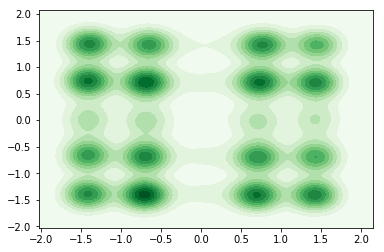

Individual: 4
Individual: 4, Epoch: 1/100, Step: 0, D_Loss: 1.031006097793579, G Loss: 0.984515905380249
Individual: 4, Epoch: 6/100, Step: 500, D_Loss: 1.0315179824829102, G Loss: 1.1166276931762695
Individual: 4, Epoch: 11/100, Step: 1000, D_Loss: 1.1811776161193848, G Loss: 1.1059362888336182
Individual: 4, Epoch: 16/100, Step: 1500, D_Loss: 1.1440162658691406, G Loss: 1.1270166635513306
Individual: 4, Epoch: 21/100, Step: 2000, D_Loss: 1.1088836193084717, G Loss: 1.3591456413269043
Individual: 4, Epoch: 26/100, Step: 2500, D_Loss: 1.0969643592834473, G Loss: 1.1587140560150146
Individual: 4, Epoch: 31/100, Step: 3000, D_Loss: 1.0572869777679443, G Loss: 0.965976357460022
Individual: 4, Epoch: 36/100, Step: 3500, D_Loss: 1.167455792427063, G Loss: 1.073265552520752
Individual: 4, Epoch: 41/100, Step: 4000, D_Loss: 1.2529577016830444, G Loss: 1.2443264722824097
Individual: 4, Epoch: 46/100, Step: 4500, D_Loss: 1.0904854536056519, G Loss: 0.9144011735916138
Individual: 4, Epoch: 51/10

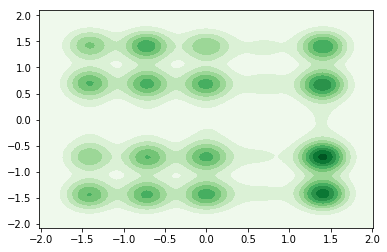

Individual: 5
Individual: 5, Epoch: 1/100, Step: 0, D_Loss: 1.1905314922332764, G Loss: 1.2513959407806396
Individual: 5, Epoch: 6/100, Step: 500, D_Loss: 1.0506747961044312, G Loss: 1.299493670463562
Individual: 5, Epoch: 11/100, Step: 1000, D_Loss: 1.002003788948059, G Loss: 1.4014596939086914
Individual: 5, Epoch: 16/100, Step: 1500, D_Loss: 1.0226253271102905, G Loss: 1.144313097000122
Individual: 5, Epoch: 21/100, Step: 2000, D_Loss: 1.1095662117004395, G Loss: 1.1904829740524292
Individual: 5, Epoch: 26/100, Step: 2500, D_Loss: 0.9985626935958862, G Loss: 1.3378431797027588
Individual: 5, Epoch: 31/100, Step: 3000, D_Loss: 1.1184028387069702, G Loss: 1.1425319910049438
Individual: 5, Epoch: 36/100, Step: 3500, D_Loss: 0.9878407120704651, G Loss: 1.1752090454101562
Individual: 5, Epoch: 41/100, Step: 4000, D_Loss: 1.021899938583374, G Loss: 1.2611994743347168
Individual: 5, Epoch: 46/100, Step: 4500, D_Loss: 1.1660315990447998, G Loss: 1.1010137796401978
Individual: 5, Epoch: 51/1

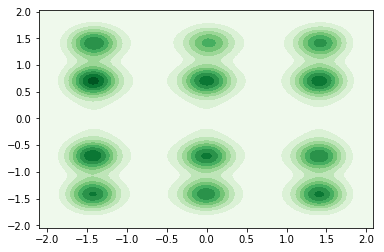

Crossover....Generation: 1
Generation: 2
Training for Evaluation....Generation: 2
Individual: 1
Individual: 1, Epoch: 1/100, Step: 0, D_Loss: 1.44691002368927, G Loss: 0.9638259410858154
Individual: 1, Epoch: 6/100, Step: 500, D_Loss: 1.1558184623718262, G Loss: 0.9775162935256958
Individual: 1, Epoch: 11/100, Step: 1000, D_Loss: 1.2255632877349854, G Loss: 0.8669261336326599
Individual: 1, Epoch: 16/100, Step: 1500, D_Loss: 1.2820590734481812, G Loss: 0.9521960616111755
Individual: 1, Epoch: 21/100, Step: 2000, D_Loss: 1.178249478340149, G Loss: 0.981615424156189
Individual: 1, Epoch: 26/100, Step: 2500, D_Loss: 1.1785829067230225, G Loss: 0.8959913849830627
Individual: 1, Epoch: 31/100, Step: 3000, D_Loss: 1.242532730102539, G Loss: 0.918651819229126
Individual: 1, Epoch: 36/100, Step: 3500, D_Loss: 1.1494450569152832, G Loss: 1.1552937030792236
Individual: 1, Epoch: 41/100, Step: 4000, D_Loss: 1.1601719856262207, G Loss: 0.8377788066864014
Individual: 1, Epoch: 46/100, Step: 4500, D

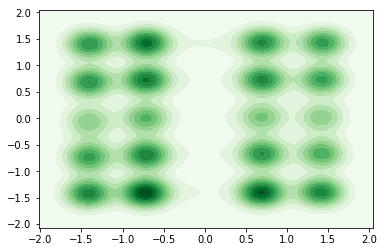

Individual: 2
Individual: 2, Epoch: 1/100, Step: 0, D_Loss: 1.5770677328109741, G Loss: 0.9335237145423889
Individual: 2, Epoch: 6/100, Step: 500, D_Loss: 1.2908521890640259, G Loss: 0.9585269093513489
Individual: 2, Epoch: 11/100, Step: 1000, D_Loss: 1.2363481521606445, G Loss: 1.0306546688079834
Individual: 2, Epoch: 16/100, Step: 1500, D_Loss: 1.2286577224731445, G Loss: 0.9850241541862488
Individual: 2, Epoch: 21/100, Step: 2000, D_Loss: 1.2319804430007935, G Loss: 0.9816952347755432
Individual: 2, Epoch: 26/100, Step: 2500, D_Loss: 1.1990985870361328, G Loss: 0.9794655442237854
Individual: 2, Epoch: 31/100, Step: 3000, D_Loss: 1.298090934753418, G Loss: 0.7953234910964966
Individual: 2, Epoch: 36/100, Step: 3500, D_Loss: 1.2345322370529175, G Loss: 0.8847576975822449
Individual: 2, Epoch: 41/100, Step: 4000, D_Loss: 1.2691140174865723, G Loss: 0.9166645407676697
Individual: 2, Epoch: 46/100, Step: 4500, D_Loss: 1.2932971715927124, G Loss: 0.9890843629837036
Individual: 2, Epoch: 5

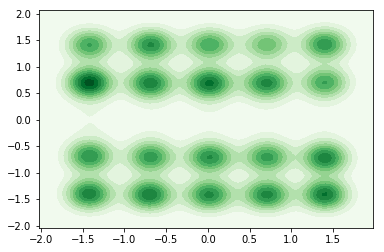

Individual: 3
Individual: 3, Epoch: 1/100, Step: 0, D_Loss: 1.247215986251831, G Loss: 1.0250364542007446
Individual: 3, Epoch: 6/100, Step: 500, D_Loss: 1.2873649597167969, G Loss: 0.8789296746253967
Individual: 3, Epoch: 11/100, Step: 1000, D_Loss: 1.2334038019180298, G Loss: 0.9924248456954956
Individual: 3, Epoch: 16/100, Step: 1500, D_Loss: 1.24104905128479, G Loss: 0.8955172300338745
Individual: 3, Epoch: 21/100, Step: 2000, D_Loss: 1.2399522066116333, G Loss: 0.9042556881904602
Individual: 3, Epoch: 26/100, Step: 2500, D_Loss: 1.2437725067138672, G Loss: 0.8498001098632812
Individual: 3, Epoch: 31/100, Step: 3000, D_Loss: 1.2054754495620728, G Loss: 1.0065659284591675
Individual: 3, Epoch: 36/100, Step: 3500, D_Loss: 1.223387360572815, G Loss: 0.9131903648376465
Individual: 3, Epoch: 41/100, Step: 4000, D_Loss: 1.2323379516601562, G Loss: 1.022097110748291
Individual: 3, Epoch: 46/100, Step: 4500, D_Loss: 1.2615094184875488, G Loss: 1.1000287532806396
Individual: 3, Epoch: 51/10

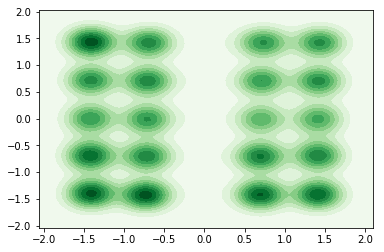

Individual: 4
Individual: 4, Epoch: 1/100, Step: 0, D_Loss: 1.9050605297088623, G Loss: 1.1010360717773438
Individual: 4, Epoch: 6/100, Step: 500, D_Loss: 1.294454574584961, G Loss: 0.8575224876403809
Individual: 4, Epoch: 11/100, Step: 1000, D_Loss: 1.2403326034545898, G Loss: 0.9178038239479065
Individual: 4, Epoch: 16/100, Step: 1500, D_Loss: 1.2334399223327637, G Loss: 1.1352471113204956
Individual: 4, Epoch: 21/100, Step: 2000, D_Loss: 1.3074007034301758, G Loss: 0.9501063823699951
Individual: 4, Epoch: 26/100, Step: 2500, D_Loss: 1.343998908996582, G Loss: 0.866868793964386
Individual: 4, Epoch: 31/100, Step: 3000, D_Loss: 1.2843047380447388, G Loss: 0.9355670213699341
Individual: 4, Epoch: 36/100, Step: 3500, D_Loss: 1.25241219997406, G Loss: 1.0159871578216553
Individual: 4, Epoch: 41/100, Step: 4000, D_Loss: 1.210580825805664, G Loss: 0.8586421012878418
Individual: 4, Epoch: 46/100, Step: 4500, D_Loss: 1.2618937492370605, G Loss: 0.7556509971618652
Individual: 4, Epoch: 51/100

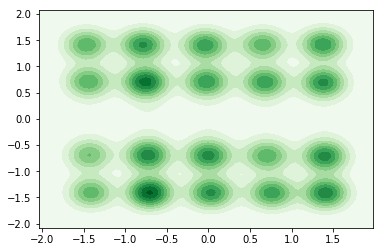

Individual: 5
Individual: 5, Epoch: 1/100, Step: 0, D_Loss: 1.283877968788147, G Loss: 0.8555251955986023
Individual: 5, Epoch: 6/100, Step: 500, D_Loss: 1.338154673576355, G Loss: 0.898586630821228
Individual: 5, Epoch: 11/100, Step: 1000, D_Loss: 1.2521177530288696, G Loss: 0.9033629894256592
Individual: 5, Epoch: 16/100, Step: 1500, D_Loss: 1.2375149726867676, G Loss: 0.9908324480056763
Individual: 5, Epoch: 21/100, Step: 2000, D_Loss: 1.2560023069381714, G Loss: 0.9265685081481934
Individual: 5, Epoch: 26/100, Step: 2500, D_Loss: 1.2302272319793701, G Loss: 0.8651628494262695
Individual: 5, Epoch: 31/100, Step: 3000, D_Loss: 1.3084734678268433, G Loss: 1.0057841539382935
Individual: 5, Epoch: 36/100, Step: 3500, D_Loss: 1.2399840354919434, G Loss: 0.8486561179161072
Individual: 5, Epoch: 41/100, Step: 4000, D_Loss: 1.3304882049560547, G Loss: 1.071013331413269
Individual: 5, Epoch: 46/100, Step: 4500, D_Loss: 1.227527379989624, G Loss: 0.9277036190032959
Individual: 5, Epoch: 51/10

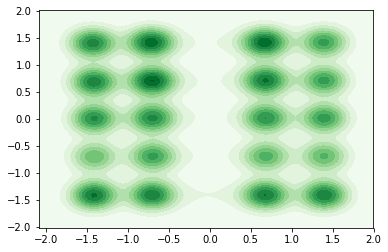

Individual: 6
Individual: 6, Epoch: 1/100, Step: 0, D_Loss: 1.3284690380096436, G Loss: 0.7710301876068115
Individual: 6, Epoch: 6/100, Step: 500, D_Loss: 1.2566683292388916, G Loss: 0.8953015804290771
Individual: 6, Epoch: 11/100, Step: 1000, D_Loss: 1.2085105180740356, G Loss: 0.8943353295326233
Individual: 6, Epoch: 16/100, Step: 1500, D_Loss: 1.2126121520996094, G Loss: 0.7735394239425659
Individual: 6, Epoch: 21/100, Step: 2000, D_Loss: 1.2767000198364258, G Loss: 1.0355018377304077
Individual: 6, Epoch: 26/100, Step: 2500, D_Loss: 1.3691688776016235, G Loss: 0.9054712653160095
Individual: 6, Epoch: 31/100, Step: 3000, D_Loss: 1.2979426383972168, G Loss: 0.8130284547805786
Individual: 6, Epoch: 36/100, Step: 3500, D_Loss: 1.2756643295288086, G Loss: 1.1676764488220215
Individual: 6, Epoch: 41/100, Step: 4000, D_Loss: 1.212113618850708, G Loss: 1.0054123401641846
Individual: 6, Epoch: 46/100, Step: 4500, D_Loss: 1.36234712600708, G Loss: 0.8486339449882507
Individual: 6, Epoch: 51/

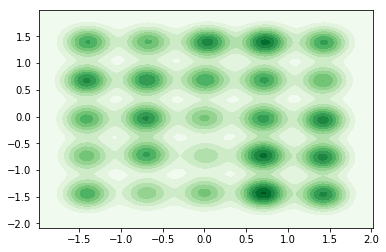

Individual: 7
Individual: 7, Epoch: 1/100, Step: 0, D_Loss: 1.7238320112228394, G Loss: 0.9861220717430115
Individual: 7, Epoch: 6/100, Step: 500, D_Loss: 1.1350382566452026, G Loss: 1.0423307418823242
Individual: 7, Epoch: 11/100, Step: 1000, D_Loss: 1.0555927753448486, G Loss: 1.049335241317749
Individual: 7, Epoch: 16/100, Step: 1500, D_Loss: 1.079246997833252, G Loss: 1.0714353322982788
Individual: 7, Epoch: 21/100, Step: 2000, D_Loss: 1.1377804279327393, G Loss: 1.3291873931884766
Individual: 7, Epoch: 26/100, Step: 2500, D_Loss: 1.1645570993423462, G Loss: 1.0992380380630493
Individual: 7, Epoch: 31/100, Step: 3000, D_Loss: 1.0838416814804077, G Loss: 1.1928770542144775
Individual: 7, Epoch: 36/100, Step: 3500, D_Loss: 1.1151221990585327, G Loss: 1.2237789630889893
Individual: 7, Epoch: 41/100, Step: 4000, D_Loss: 1.0908316373825073, G Loss: 1.3744938373565674
Individual: 7, Epoch: 46/100, Step: 4500, D_Loss: 1.1088634729385376, G Loss: 1.341647982597351
Individual: 7, Epoch: 51/

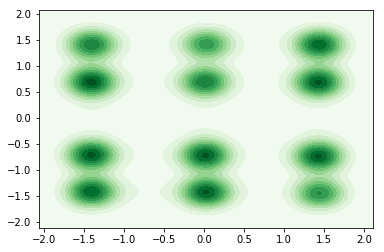

Individual: 8
Individual: 8, Epoch: 1/100, Step: 0, D_Loss: 1.2917793989181519, G Loss: 0.9810484647750854
Individual: 8, Epoch: 6/100, Step: 500, D_Loss: 1.1165286302566528, G Loss: 1.129427433013916
Individual: 8, Epoch: 11/100, Step: 1000, D_Loss: 1.1187520027160645, G Loss: 1.1325881481170654
Individual: 8, Epoch: 16/100, Step: 1500, D_Loss: 1.1637624502182007, G Loss: 1.067431926727295
Individual: 8, Epoch: 21/100, Step: 2000, D_Loss: 1.0406126976013184, G Loss: 1.0660157203674316
Individual: 8, Epoch: 26/100, Step: 2500, D_Loss: 1.1687266826629639, G Loss: 1.1645660400390625
Individual: 8, Epoch: 31/100, Step: 3000, D_Loss: 1.1741724014282227, G Loss: 1.1858196258544922
Individual: 8, Epoch: 36/100, Step: 3500, D_Loss: 1.1346564292907715, G Loss: 1.107496976852417
Individual: 8, Epoch: 41/100, Step: 4000, D_Loss: 1.1099226474761963, G Loss: 1.0714926719665527
Individual: 8, Epoch: 46/100, Step: 4500, D_Loss: 1.0794720649719238, G Loss: 1.0819313526153564
Individual: 8, Epoch: 51/

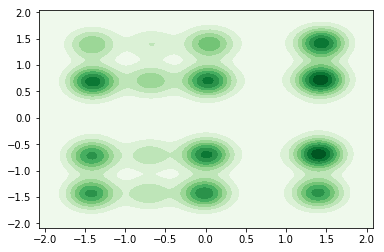

Individual: 9
Individual: 9, Epoch: 1/100, Step: 0, D_Loss: 1.3133172988891602, G Loss: 0.7862219214439392
Individual: 9, Epoch: 6/100, Step: 500, D_Loss: 1.2680277824401855, G Loss: 1.023315668106079
Individual: 9, Epoch: 11/100, Step: 1000, D_Loss: 1.189505696296692, G Loss: 0.8824059963226318
Individual: 9, Epoch: 16/100, Step: 1500, D_Loss: 1.2582913637161255, G Loss: 0.9582610130310059
Individual: 9, Epoch: 21/100, Step: 2000, D_Loss: 1.2202017307281494, G Loss: 1.093665599822998
Individual: 9, Epoch: 26/100, Step: 2500, D_Loss: 1.2800450325012207, G Loss: 0.894461989402771
Individual: 9, Epoch: 31/100, Step: 3000, D_Loss: 1.231173038482666, G Loss: 1.05645751953125
Individual: 9, Epoch: 36/100, Step: 3500, D_Loss: 1.1784698963165283, G Loss: 1.0478054285049438
Individual: 9, Epoch: 41/100, Step: 4000, D_Loss: 1.226560115814209, G Loss: 0.9878443479537964
Individual: 9, Epoch: 46/100, Step: 4500, D_Loss: 1.2774138450622559, G Loss: 0.9991908073425293
Individual: 9, Epoch: 51/100, 

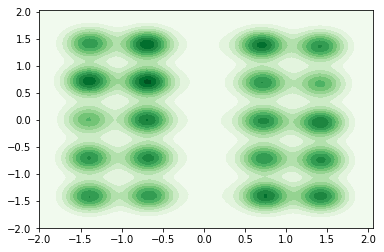

Individual: 10
Individual: 10, Epoch: 1/100, Step: 0, D_Loss: 1.6238112449645996, G Loss: 0.7917453050613403
Individual: 10, Epoch: 6/100, Step: 500, D_Loss: 1.4024076461791992, G Loss: 1.0191506147384644
Individual: 10, Epoch: 11/100, Step: 1000, D_Loss: 1.4312142133712769, G Loss: 0.8819431662559509
Individual: 10, Epoch: 16/100, Step: 1500, D_Loss: 1.3417060375213623, G Loss: 0.7218583226203918
Individual: 10, Epoch: 21/100, Step: 2000, D_Loss: 1.3938086032867432, G Loss: 0.9093223214149475
Individual: 10, Epoch: 26/100, Step: 2500, D_Loss: 1.2848625183105469, G Loss: 0.8163620829582214
Individual: 10, Epoch: 31/100, Step: 3000, D_Loss: 1.4377493858337402, G Loss: 0.796545147895813
Individual: 10, Epoch: 36/100, Step: 3500, D_Loss: 1.4190526008605957, G Loss: 0.8557983636856079
Individual: 10, Epoch: 41/100, Step: 4000, D_Loss: 1.4829463958740234, G Loss: 0.9598756432533264
Individual: 10, Epoch: 46/100, Step: 4500, D_Loss: 1.3518630266189575, G Loss: 0.8597604632377625
Individual: 

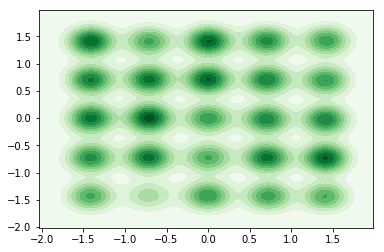

Mutating....Generation: 2
Individual: 1
Individual: 1, Epoch: 1/100, Step: 0, D_Loss: 1.4014499187469482, G Loss: 0.8232032060623169
Individual: 1, Epoch: 6/100, Step: 500, D_Loss: 1.3747663497924805, G Loss: 0.7807470560073853
Individual: 1, Epoch: 11/100, Step: 1000, D_Loss: 1.475809097290039, G Loss: 0.752219021320343
Individual: 1, Epoch: 16/100, Step: 1500, D_Loss: 1.3755176067352295, G Loss: 0.8722471594810486
Individual: 1, Epoch: 21/100, Step: 2000, D_Loss: 1.3987741470336914, G Loss: 0.7536766529083252
Individual: 1, Epoch: 26/100, Step: 2500, D_Loss: 1.3969759941101074, G Loss: 0.9577137231826782
Individual: 1, Epoch: 31/100, Step: 3000, D_Loss: 1.353668212890625, G Loss: 0.8120796084403992
Individual: 1, Epoch: 36/100, Step: 3500, D_Loss: 1.3597116470336914, G Loss: 0.7540336847305298
Individual: 1, Epoch: 41/100, Step: 4000, D_Loss: 1.4108155965805054, G Loss: 0.7125545740127563
Individual: 1, Epoch: 46/100, Step: 4500, D_Loss: 1.4677646160125732, G Loss: 0.77585369348526
I

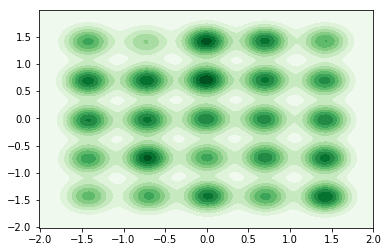

Individual: 2
Individual: 2, Epoch: 1/100, Step: 0, D_Loss: 1.3936731815338135, G Loss: 0.7854322195053101
Individual: 2, Epoch: 6/100, Step: 500, D_Loss: 1.308102011680603, G Loss: 0.6876934766769409
Individual: 2, Epoch: 11/100, Step: 1000, D_Loss: 1.4419593811035156, G Loss: 0.8351995348930359
Individual: 2, Epoch: 16/100, Step: 1500, D_Loss: 1.4119868278503418, G Loss: 0.825690507888794
Individual: 2, Epoch: 21/100, Step: 2000, D_Loss: 1.388956069946289, G Loss: 0.721915066242218
Individual: 2, Epoch: 26/100, Step: 2500, D_Loss: 1.378198266029358, G Loss: 1.0425686836242676
Individual: 2, Epoch: 31/100, Step: 3000, D_Loss: 1.446828842163086, G Loss: 0.8078429698944092
Individual: 2, Epoch: 36/100, Step: 3500, D_Loss: 1.454900860786438, G Loss: 0.783023476600647
Individual: 2, Epoch: 41/100, Step: 4000, D_Loss: 1.397560954093933, G Loss: 0.7397549152374268
Individual: 2, Epoch: 46/100, Step: 4500, D_Loss: 1.3955398797988892, G Loss: 0.6856980323791504
Individual: 2, Epoch: 51/100, S

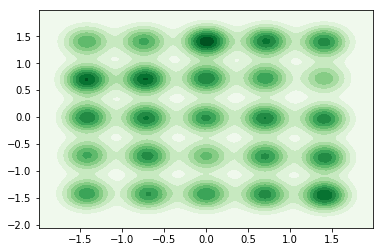

Individual: 3
Individual: 3, Epoch: 1/100, Step: 0, D_Loss: 1.4479055404663086, G Loss: 0.9319081902503967
Individual: 3, Epoch: 6/100, Step: 500, D_Loss: 1.170370101928711, G Loss: 0.911902666091919
Individual: 3, Epoch: 11/100, Step: 1000, D_Loss: 1.258814811706543, G Loss: 0.8863106966018677
Individual: 3, Epoch: 16/100, Step: 1500, D_Loss: 1.2227087020874023, G Loss: 0.8159608840942383
Individual: 3, Epoch: 21/100, Step: 2000, D_Loss: 1.2000653743743896, G Loss: 1.0837891101837158
Individual: 3, Epoch: 26/100, Step: 2500, D_Loss: 1.2884762287139893, G Loss: 1.0441337823867798
Individual: 3, Epoch: 31/100, Step: 3000, D_Loss: 1.29579758644104, G Loss: 1.002415657043457
Individual: 3, Epoch: 36/100, Step: 3500, D_Loss: 1.226746916770935, G Loss: 0.8858638405799866
Individual: 3, Epoch: 41/100, Step: 4000, D_Loss: 1.2168219089508057, G Loss: 0.9445562362670898
Individual: 3, Epoch: 46/100, Step: 4500, D_Loss: 1.2810828685760498, G Loss: 0.9966530203819275
Individual: 3, Epoch: 51/100,

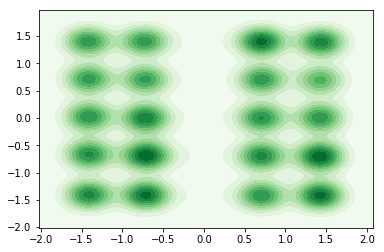

Individual: 4
Individual: 4, Epoch: 1/100, Step: 0, D_Loss: 1.2134290933609009, G Loss: 0.7990372180938721
Individual: 4, Epoch: 6/100, Step: 500, D_Loss: 1.2214058637619019, G Loss: 0.9364425539970398
Individual: 4, Epoch: 11/100, Step: 1000, D_Loss: 1.2116665840148926, G Loss: 0.8104050159454346
Individual: 4, Epoch: 16/100, Step: 1500, D_Loss: 1.2513105869293213, G Loss: 0.9090149402618408
Individual: 4, Epoch: 21/100, Step: 2000, D_Loss: 1.2119548320770264, G Loss: 0.9164356589317322
Individual: 4, Epoch: 26/100, Step: 2500, D_Loss: 1.1772828102111816, G Loss: 0.9745966196060181
Individual: 4, Epoch: 31/100, Step: 3000, D_Loss: 1.270079493522644, G Loss: 0.8335360288619995
Individual: 4, Epoch: 36/100, Step: 3500, D_Loss: 1.2639580965042114, G Loss: 0.8566343784332275
Individual: 4, Epoch: 41/100, Step: 4000, D_Loss: 1.2723188400268555, G Loss: 0.8755840063095093
Individual: 4, Epoch: 46/100, Step: 4500, D_Loss: 1.2740180492401123, G Loss: 0.8294929265975952
Individual: 4, Epoch: 5

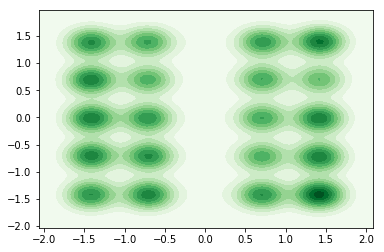

Individual: 5
Individual: 5, Epoch: 1/100, Step: 0, D_Loss: 1.264845371246338, G Loss: 0.9506679773330688
Individual: 5, Epoch: 6/100, Step: 500, D_Loss: 1.2031798362731934, G Loss: 0.8754976987838745
Individual: 5, Epoch: 11/100, Step: 1000, D_Loss: 1.1752915382385254, G Loss: 0.9900358319282532
Individual: 5, Epoch: 16/100, Step: 1500, D_Loss: 1.1933101415634155, G Loss: 0.8895339965820312
Individual: 5, Epoch: 21/100, Step: 2000, D_Loss: 1.2622828483581543, G Loss: 0.8871726989746094
Individual: 5, Epoch: 26/100, Step: 2500, D_Loss: 1.265247106552124, G Loss: 0.8634655475616455
Individual: 5, Epoch: 31/100, Step: 3000, D_Loss: 1.1646063327789307, G Loss: 0.9797272682189941
Individual: 5, Epoch: 36/100, Step: 3500, D_Loss: 1.1238240003585815, G Loss: 0.9478603601455688
Individual: 5, Epoch: 41/100, Step: 4000, D_Loss: 1.2243224382400513, G Loss: 0.9305358529090881
Individual: 5, Epoch: 46/100, Step: 4500, D_Loss: 1.2511011362075806, G Loss: 0.8050510883331299
Individual: 5, Epoch: 51

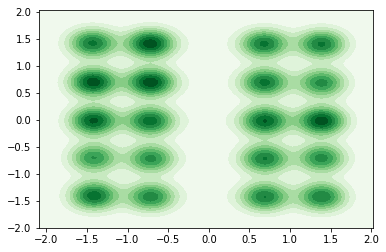

Crossover....Generation: 2


NameError: ignored

In [24]:
Generations = 2

G, D = GA(Generations, population)



Generator: 1


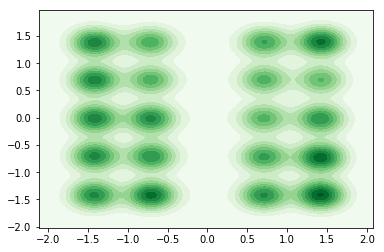

Generator: 2


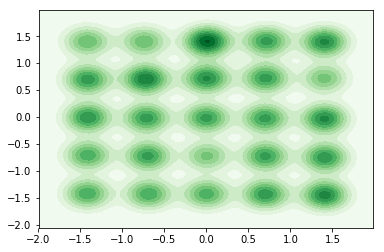

Generator: 3


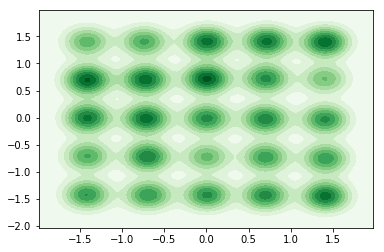

Generator: 4


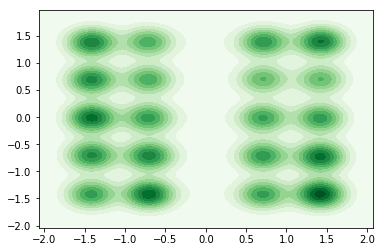

Generator: 5


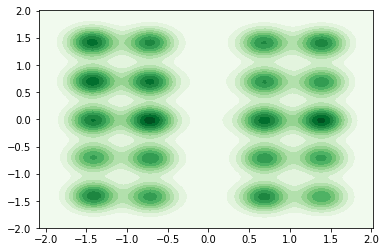

Generator: 6


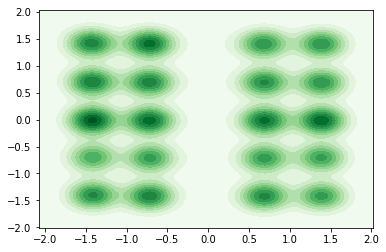

Generator: 7


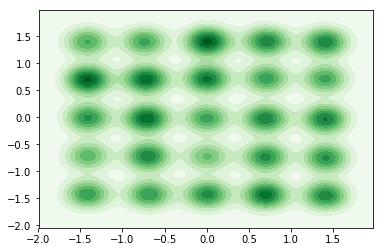

Generator: 8


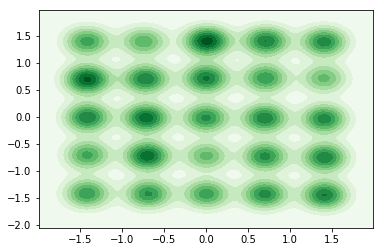

Generator: 9


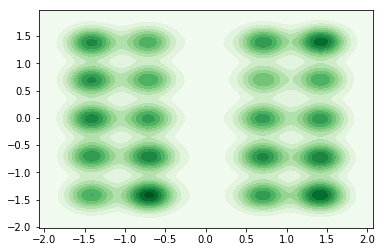

Generator: 10


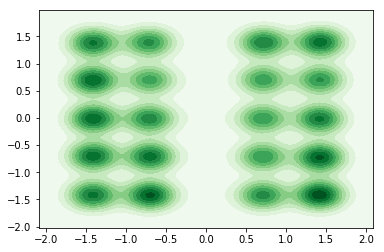

In [29]:
visualize_gens(G)

In [0]:
r = [1,2,3,4,5,6]
rs = sorted(range(len(r)), key=lambda i: r[i], reverse=False)[:best_per_gen]

T = [r[rsi] for rsi in rs]

print(T)